In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import graphviz
import matplotlib

In [2]:
df= pd.read_csv("file1.csv",index_col='tripdate',parse_dates=['start_time','stop_time'],error_bad_lines=True, warn_bad_lines=True)

In [4]:
# Create subset of only the numeric columns
numeric_df =df.select_dtypes(include=['int64','int','float']).astype('float')

# Print the column names contained in so_survey_df_num
print(numeric_df.columns)


Index(['trip_duration', 'distance', 'rain', 'wind', 'speed', 'num_trips_day',
       'temp_mean'],
      dtype='object')


In [5]:
# categorical variables
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weather'] = df.weather.astype('category')
df['month'] = df.month.astype('category')
df['year'] = df.year.astype('category')
df['hour'] = df.hour.astype('category')
df['weekend'] = df['weekend'].astype('category')
df['from_station_id'] = df['from_station_id'].astype('category')
df['to_station_id'] = df['to_station_id'].astype('category')
df['event_types'] = df['event_types'].astype('category')

In [6]:
df.dtypes

start_time         datetime64[ns]
stop_time          datetime64[ns]
trip_duration             float64
from_station_id          category
to_station_id            category
user_type                  object
season                   category
holiday                  category
walk_score                 object
transit_score              object
bike_score                 object
distance                  float64
rain                      float64
wind                      float64
weather                  category
year                     category
weekend                  category
speed                     float64
weekday                  category
num_trips_day             float64
hour                     category
month                    category
temp_mean                 float64
event_types              category
dtype: object

In [7]:
df.drop(['start_time','stop_time'], axis = 1,inplace = True)

__Encoding:__
    
To use categorical variables in a machine learning model, we first need to represent them in a quantitative way. We will make our own transformer, which applies the LabelEncoder in each of the relevant features. Then, let’s try to apply the OneHotEncoder directly to both the training and test sets using category encoders.

In [8]:
import category_encoders as ce
from category_encoders import *
le = LabelEncoder()
numeric_cols = ['trip_duration','distance', 'rain', 'wind', 'speed','hour','temp_mean']
label_cat_features = ['from_station_id','to_station_id', 'month','event_types']
ohe_cat_features =  ['season','year','weather','user_type', 'walk_score','transit_score','weekend','weekday', 'bike_score','holiday']
#ord_features = ['start_time', 'stop_time']

X , y = df.drop('num_trips_day', 1).values, df.num_trips_day.values
#df.drop(['start_time','stop_time'], axis = 1, inplace = True)
X_train_df, X_test_df, y_train, y_test = train_test_split(df.drop('num_trips_day', 1), df.num_trips_day, 
                                                    test_size=0.33, random_state=42)


def encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features):
   
    for x in label_cat_features:
        names = le.fit_transform(X_train_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_train_df[x] = names
        names2 = le.transform(X_test_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_test_df[x] = names2
        
    # use one hot encoding to encode categorical features
    ohe = OneHotEncoder(cols=ohe_cat_features, use_cat_names=True).fit(X_train_df)
    # transform the datasets
    X_train_df = ohe.transform(X_train_df)
    X_test_df = ohe.transform(X_test_df)
    
    return X_train_df, X_test_df, 
df1 = encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features)

In [9]:
X_train, X_test = df1[0].astype(float),df1[1].astype(float)

In [10]:
X_train.head(2)

,trip_duration,from_station_id,to_station_id,user_type_Subscriber,user_type_Customer,season_autumn,season_spring,season_summer,season_winter,holiday_0.0,...,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour,month,temp_mean,event_types
tripdate,,,,,,,,,,,,,,,,,,,,,
2017-04-23,6.077642,23.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,17.0,3.0,3.960813,0.0
2018-07-30,5.638355,10.0,11.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,4.248495,0.0


In [11]:
#function to compare results
from sklearn.metrics import mean_squared_error, r2_score
def validate_result(model, model_name):
    
    ## Predict on the test data: y_pred scaled
    predicted = model.predict(X_test)
    # Compute and print R^2 and RMSE
    RSME_score = np.sqrt(mean_squared_error(y_test, predicted))
       
    R2_score = r2_score(y_test, predicted)
    print(model_name,':')
    
    print('R2 score: ', R2_score)
    print('RMSE: ', RSME_score)
    

In [12]:
df.columns

Index(['trip_duration', 'from_station_id', 'to_station_id', 'user_type',
       'season', 'holiday', 'walk_score', 'transit_score', 'bike_score',
       'distance', 'rain', 'wind', 'weather', 'year', 'weekend', 'speed',
       'weekday', 'num_trips_day', 'hour', 'month', 'temp_mean',
       'event_types'],
      dtype='object')

Percent of missing data: 0.0
Number of rows and columns: (163317, 22)


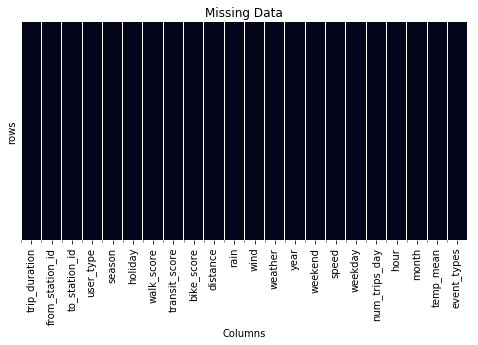

In [13]:
# Percent of total NaN values
print('Percent of missing data: {}'.format(df.isnull().sum().sum()/df.count().sum()))
print('Number of rows and columns: {}'.format(df.shape))

# Plot Visual of Nan Values
fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(df.isnull(), cbar=False)
ax.set_title('Missing Data')
ax.set_xticks(np.arange(len(df.columns)),['trip_duration', 'from_station_id', 'to_station_id', 'user_type','season', 'holiday', 'walk_score', 'transit_score', 'bike_score','distance', 'rain', 'wind', 'weather', 'year', 'weekend', 'speed','weekday', 'num_trips_day', 'hour', 'month', 'temp_mean','event_types'])
ax.set_xlabel('Columns')
ax.set_yticks([])
ax.set_ylabel('rows')
plt.show()

__Lasso:__

Lasso  performs regularization by adding to the loss function a penalty term of the absolute value of each coefficient multiplied by some alpha. This is also known as L1 regularization because the regularization term is the L1 norm of the coefficients.

[ 1.08581181e-02 -0.00000000e+00 -0.00000000e+00 -1.47893098e-02
  0.00000000e+00 -0.00000000e+00  9.78378888e-03  0.00000000e+00
 -2.62722224e-01  4.47725220e-02 -2.38528161e-17  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -2.63788002e-01 -9.27944603e-03  7.19387884e-02
 -1.23887255e-01 -0.00000000e+00  1.11871496e-01  0.00000000e+00
 -0.00000000e+00 -7.81916500e-02 -1.99547455e-03  2.38528161e-17
 -0.00000000e+00 -6.91813608e-03 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  5.63921261e-02  0.00000000e+00
  0.00000000e+00 -7.39978501e-03  1.33293346e+00 -0.00000000e+00]


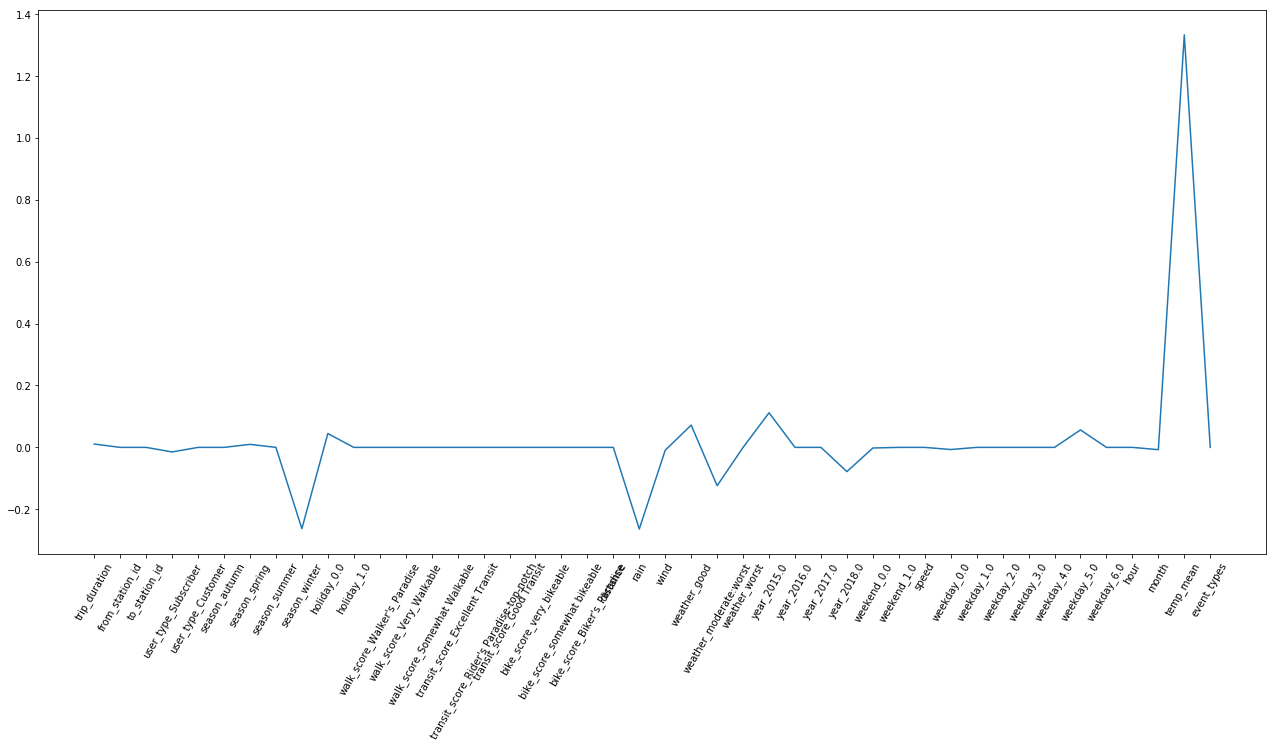

In [16]:
# Import Lasso
from sklearn.linear_model import Lasso

df_columns = pd.DataFrame(X_train)
df_columns.shape

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha = .0001,normalize = True)

# Fit the regressor to the data
lasso.fit(X_train,y_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)
fig = plt.figure(figsize=(22,10))
# Plot the coefficients
plt.plot(range(len(df_columns.columns)), lasso.coef_);
plt.xticks(range(len(df_columns.columns)), df_columns.columns.values, rotation=60)

plt.show()


In [17]:
validate_result(lasso, 'Lasso Regression')

Lasso Regression :
R2 score:  0.6788815127373728
RMSE:  0.31619049303002844


In [18]:
Tuned_models = {}
Tuned_models['Lasso_all'] = lasso
Tuned_models

{'Lasso_all': Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=True, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

__Ridge Regularization__

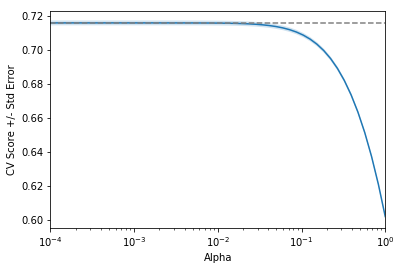

In [14]:
'''Regularization II: Ridge
 If we take the sum of the squared values of the coefficients multiplied by some alpha - like in Ridge regression 
- we would be computing the L2 norm. Here, we will fit ridge regression models over a range of different alphas, and plot cross-validated R2 
scores for each, using this function below  which plots the R2 score as well as standard error for each alpha:'''

# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()
    
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize = True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X_train, y_train,  cv=10)
    
    # Append the mean of r to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)


In [19]:
# Create a ridge regressor: ridge
ridge = Ridge(alpha = 0.01,normalize = True)


ridge_all = ridge.fit(X_train,y_train)
validate_result(ridge_all,"Ridge")
Tuned_models['Ridge_all'] = ridge_all

Ridge :
R2 score:  0.7214711516809557
RMSE:  0.29447690831174056


__Decision Tree:__

In [16]:
# Import necessary modules
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

dt = DecisionTreeRegressor(max_depth=4,
                           
                            min_samples_split=5,
                            max_leaf_nodes=10)
dt.fit(X_train,y_train)
validate_result(dt, 'Decision Tree Standard')


Decision Tree Standard :
R2 score:  0.6971487872977161
RMSE:  0.30706534949950876


In [17]:
param_grid = {
              "min_samples_split": [10, 50, 100],
              
              "min_samples_leaf": [20, 40, 60],
              "max_leaf_nodes": [5, 20, 100]
              }
grid_cv_dt = GridSearchCV(dt, param_grid, cv=5)
grid_cv_dt.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [10, 50, 100], 'min_samples_leaf': [20, 40, 60], 'max_leaf_nodes': [5, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [18]:
dt_model = grid_cv_dt.best_estimator_
print("R-Squared with cv:{}".format(grid_cv_dt.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dt.best_params_))
print("Best estimator:")
print(dt_model)

R-Squared with cv:0.7612249697299441
Best Hyperparameters::
{'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}
Best estimator:
DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=100, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


In [19]:
#with best hyperparameters
dt1 = DecisionTreeRegressor(max_depth=4,
                           min_samples_leaf= 20,
                           min_samples_split=10,
                           max_leaf_nodes=100)
dt1.fit(X_train,y_train)
validate_result(dt1, 'Decision Tree with best hyperparameters')
print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(dt1,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))



Decision Tree with best hyperparameters :
R2 score:  0.7636108507206842
RMSE:  0.27128758655964413

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.75862331 0.76402583 0.76391154 0.76126584 0.75829833]
Average 5-Fold CV Score: 0.7612249679095018


In [20]:
Tuned_models['DT_all'] = dt1

__Linear Regression using all the features:__

Now, let's perform a 5-fold cross validation on the data. By default, scikit-learn's cross_val_score() function uses R2 as the metric of choice for regression. Since we are performing 5-fold cross-validation, the function will return 5 scores. We will compute these 5 scores and then take their average.



In [21]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [
         ('scaler', StandardScaler()),
         ('reg_all',  LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# Fit the regressor to the training data
reg_all = pipeline.fit(X_train,y_train)

## Predict on the test data: y_pred scaled
y_pred = reg_all.predict(X_test)


# Compute and print R^2 and RMSE
validate_result(reg_all, 'Linear regression')

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg_all,X_train,y_train,cv = 5)
# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))




Linear regression :
R2 score:  0.7215492957540717
RMSE:  0.29443559618293375

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.71484261 0.71812039 0.71755467 0.71746402 0.71216856]
Average 5-Fold CV Score: 0.7160300492878349


In [22]:
Tuned_models['LinearReg_all'] = reg_all

__Random Forest Regression:__

In [23]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

We will now evaluate the test set RMSE of the random forests regressor rf that was trained

In [24]:
# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
# Compute and print R^2 and RMSE
#print("R^2: {}".format(rmse_test.score(X_test, y_test)))
# Print rmse_test
#print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
#Compute and print 
validate_result(rf, 'Random forest Regressor ')


Random forest Regressor  :
R2 score:  0.9992925216659934
RMSE:  0.014841326703839646


In [27]:
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [28]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest:n_estimators
# Number of features to consider at every split :max_features = ['auto', 'sqrt']
# Maximum number of levels in tree:max_depth
# Minimum number of samples required to split a node:min_samples_split 
# Minimum number of samples required at each leaf node:min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree:bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': [200, 400, 600, 800, 1000],
               'max_features': ['auto', 'sqrt'],
            
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf':  [1, 2, 4],
               }
pprint(random_grid)


{'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,  cv = 5, verbose=2, random_state=42, n_jobs = -1)


In [18]:
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 112.1min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

Copying the results:
Fitting 5 folds for each of 10 candidates, totalling 50 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 52.9min

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 112.1min finished

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}
​

In [21]:
rf_random.best_score_


0.9998203540208344

In [25]:

# Use the best parameters found from above to build the model

rf_regressor = RandomForestRegressor(n_estimators = 200,min_samples_split= 2,min_samples_leaf= 1, max_features = 'auto') 
rf_regressor.fit(X_train,y_train)

# Predicting the values 

y_pred = rf_regressor.predict(X_test) 

In [26]:
Tuned_models['RandomForest_all'] = rf_regressor

In [27]:

# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# Compute and print R^2 and RMSE
print("R^2: {}".format(rf_regressor.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of regressor: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(rf_regressor,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

R^2: 0.9992796544759983
Test set RMSE of regressor: 0.015

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.99962518 0.99980459 0.99982338 0.9997099  0.99996473]
Average 5-Fold CV Score: 0.9997855564662379


__Visualizing features importances__

Now we will determine which features were the most predictive according to the random forests regressor rf that we trained.

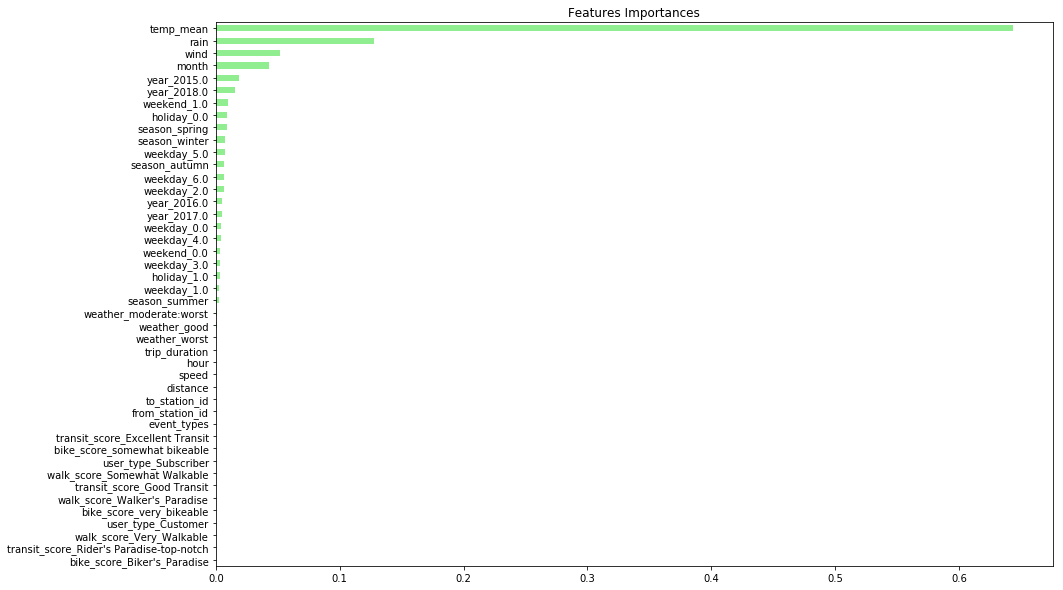

In [28]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf_regressor.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()
fig = plt.figure(figsize=(15,10))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

__Xgboost Regression:__

D:\sk\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost Regression:
R2 score standard:  0.4789367517056061
RMSE:  0.4027739502283253
R2 score of tuned model:  0.684513804258256
RMSE:  0.3134052979741757


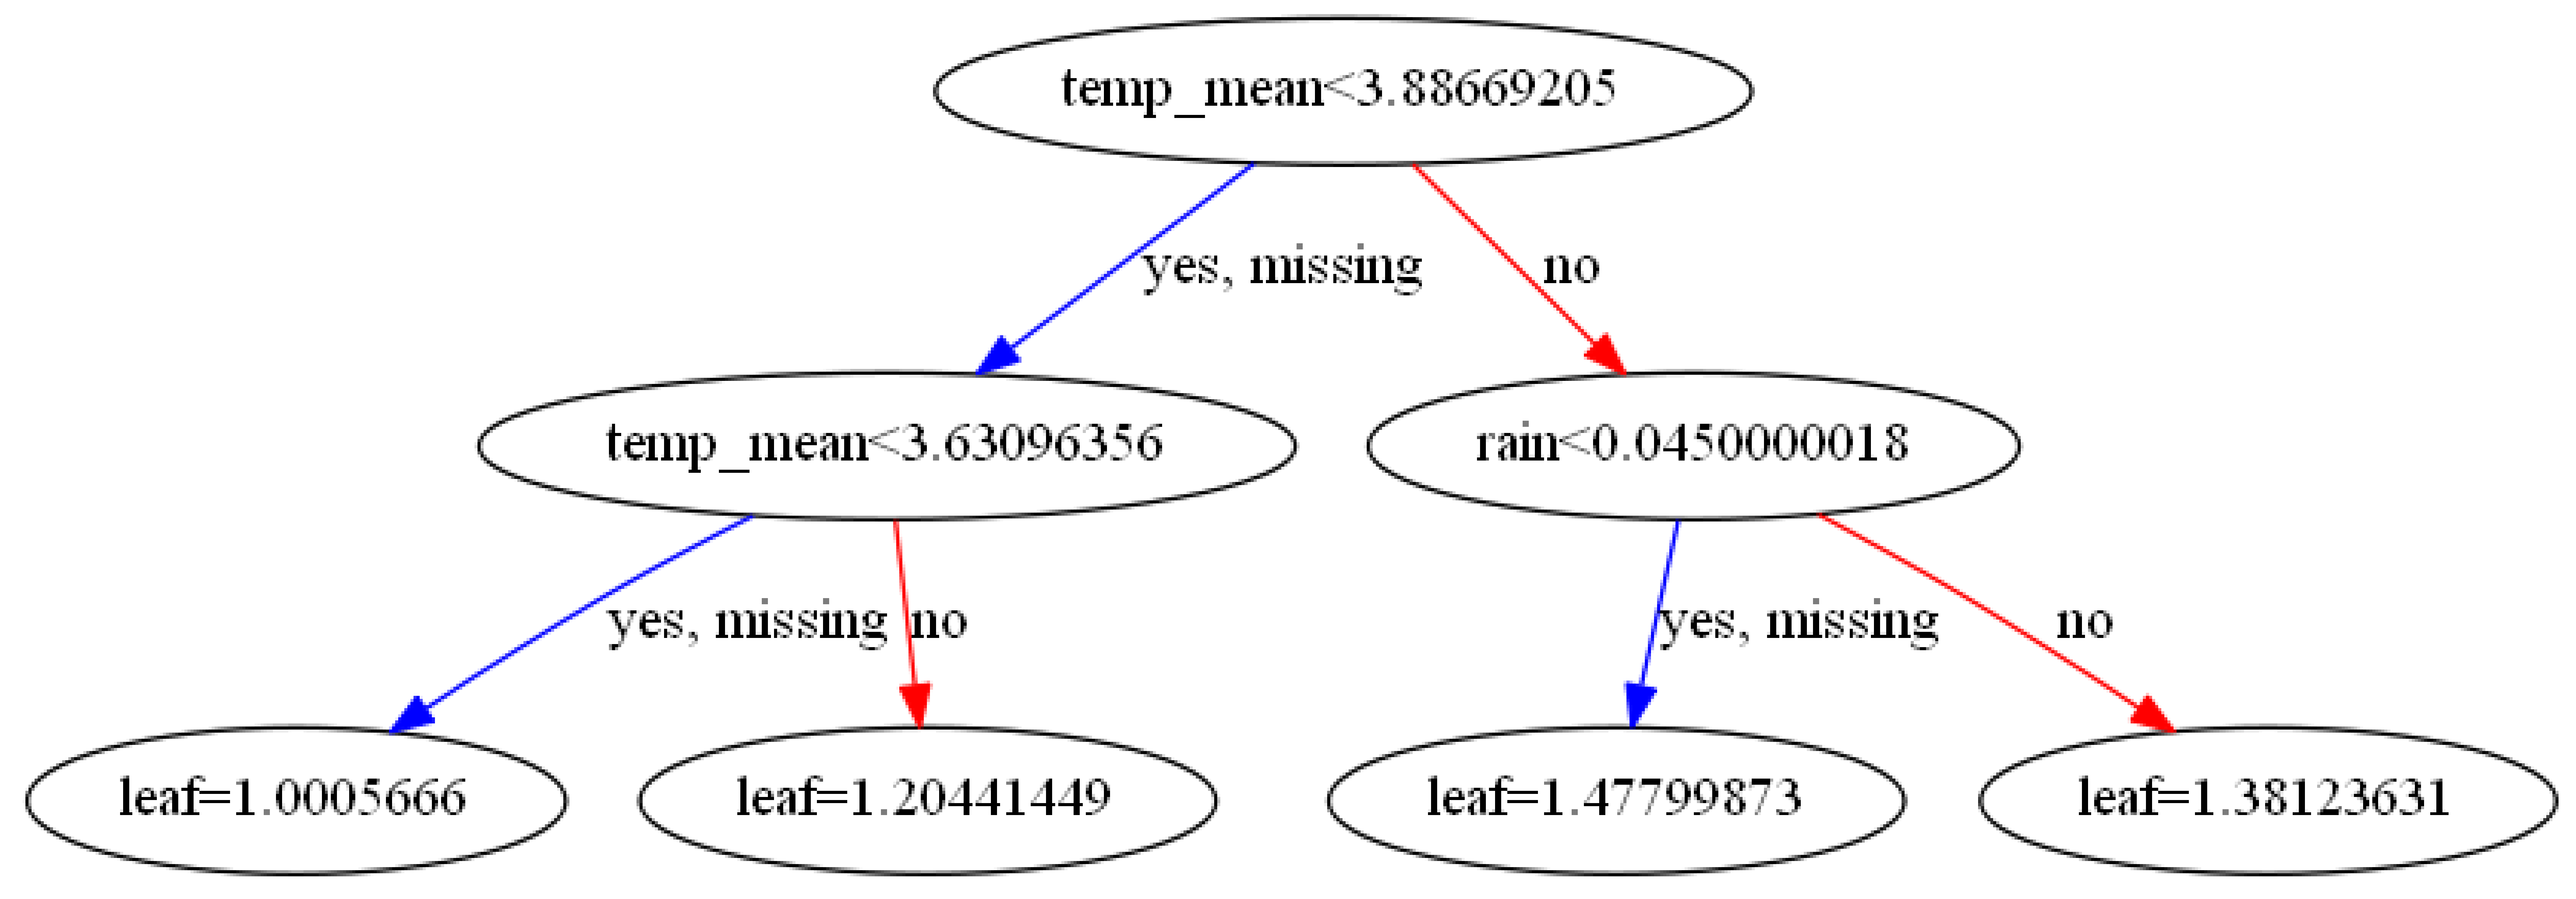

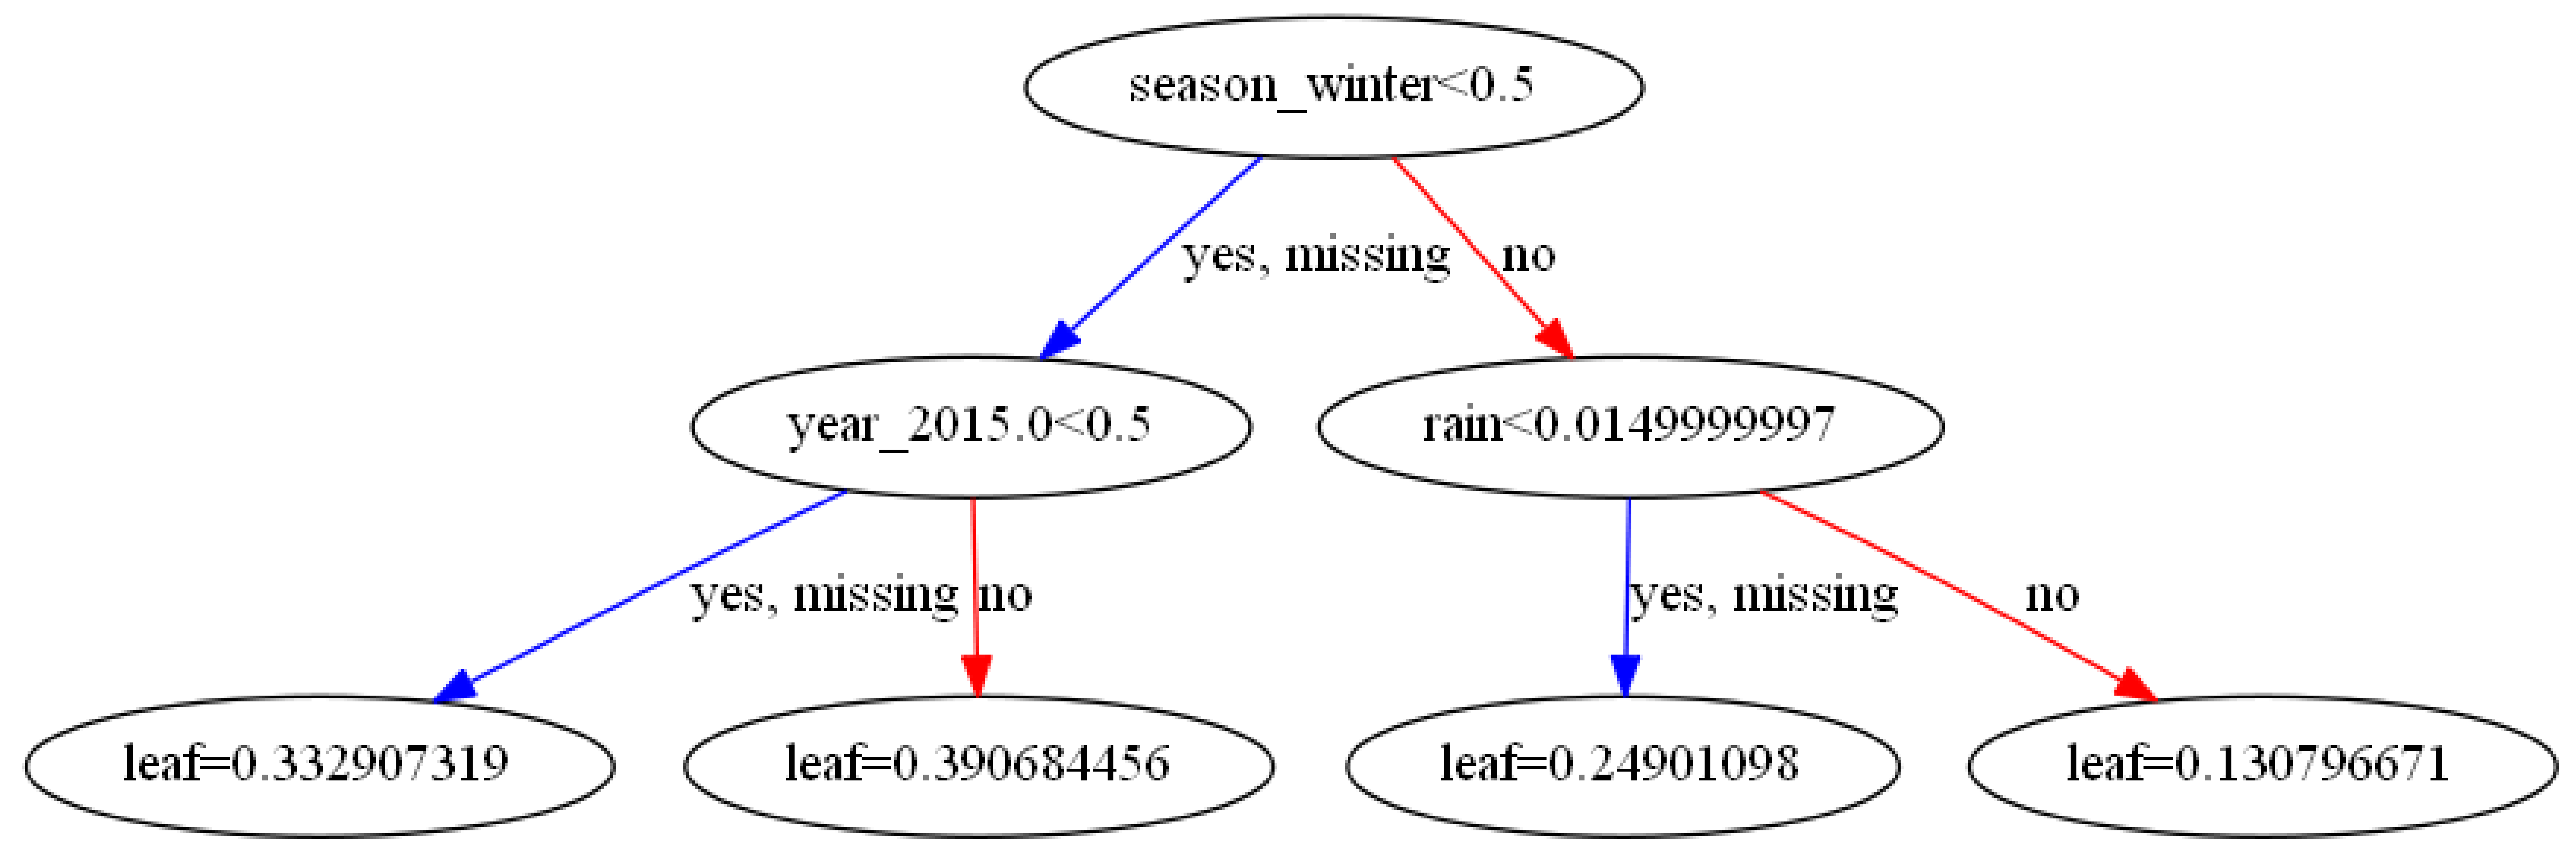

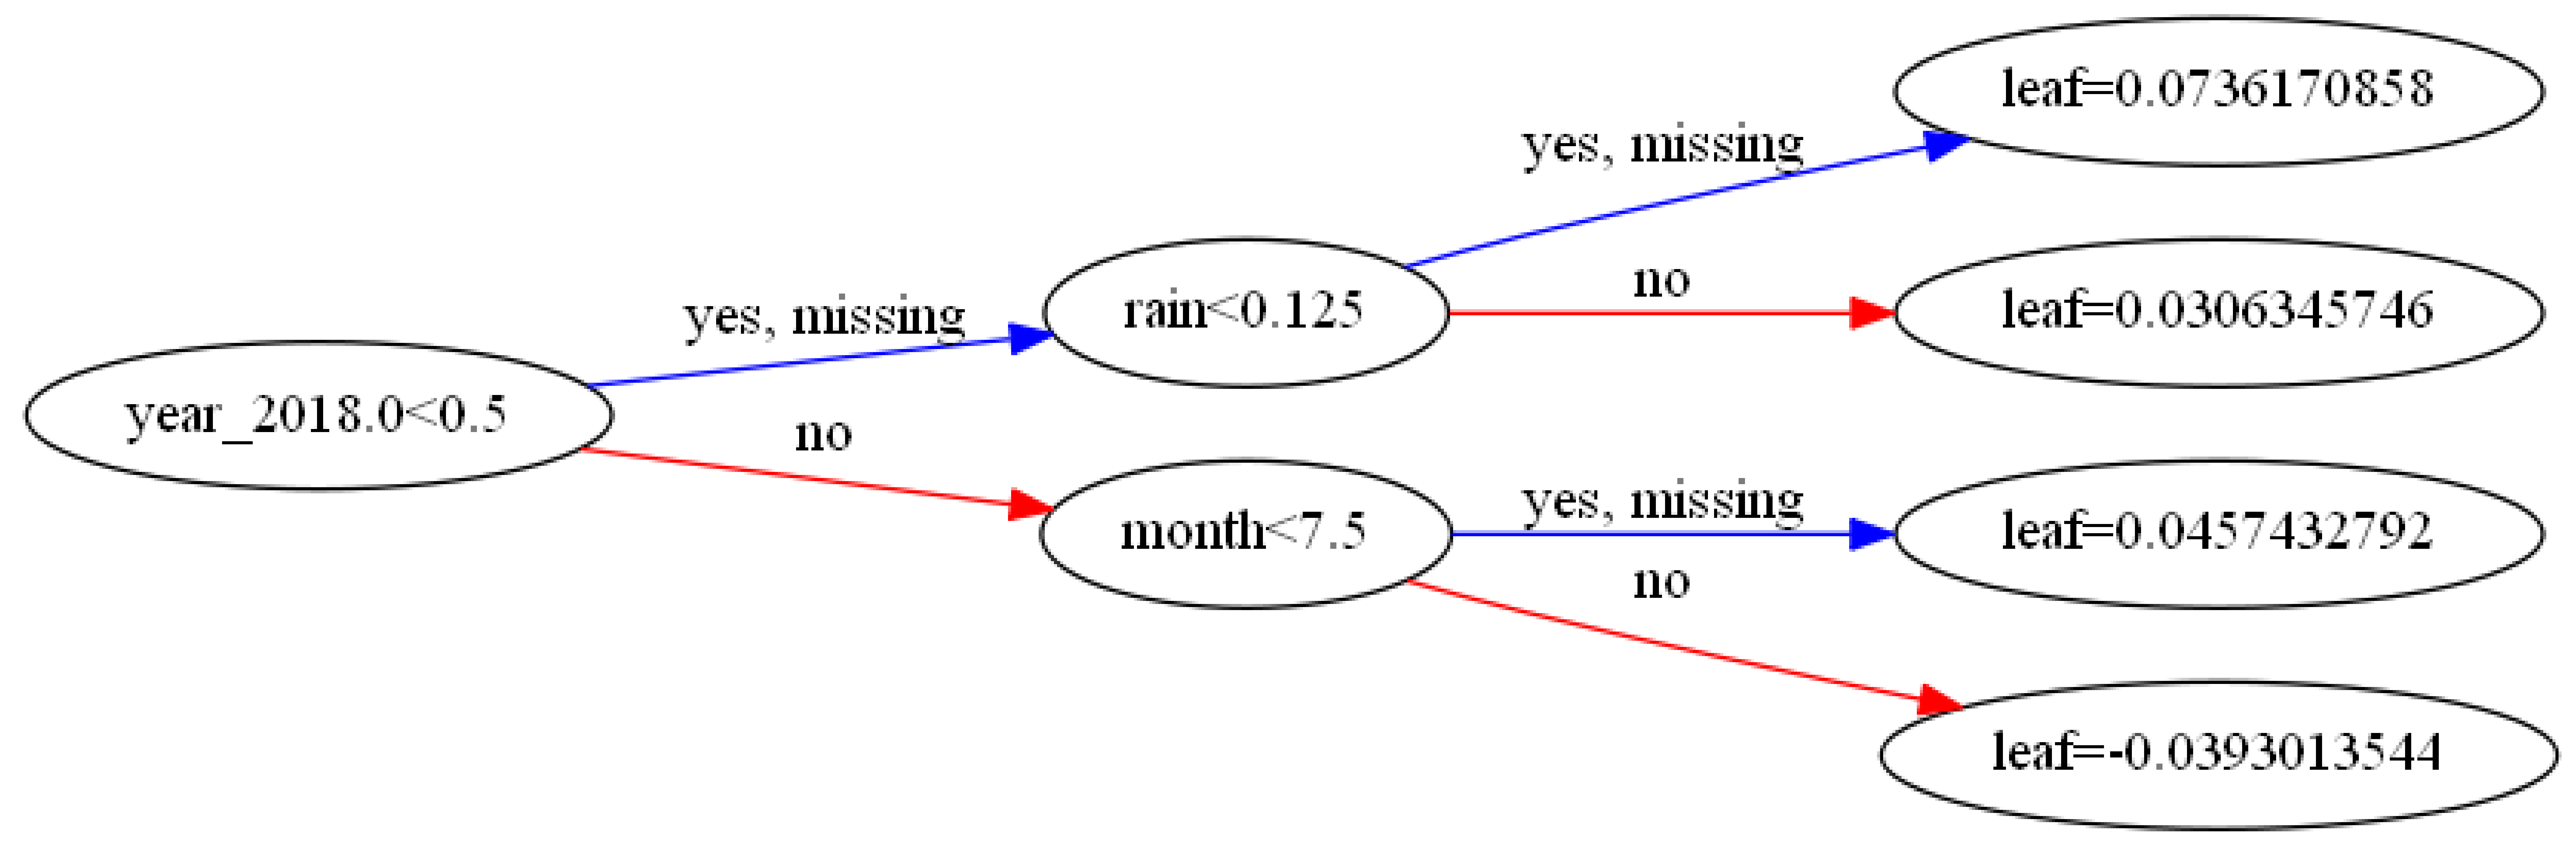

In [29]:

import xgboost as xgb


DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

params = {"booster":"gblinear","objective":"reg:squarederror"}

xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=10)

preds = xg_reg.predict(DM_test)
R2_score = r2_score(y_test, preds)
RSME_score = np.sqrt(mean_squared_error(y_test, preds))
print("Xgboost Regression:")
print('R2 score standard: ', R2_score)
print('RMSE: ', RSME_score)

"""Visualizing individual XGBoost trees
 Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire dataset."""



# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=10)
preds = xg_reg.predict(DM_test)
R2_score = r2_score(y_test, preds)
RSME_score = np.sqrt(mean_squared_error(y_test, preds))
print('R2 score of tuned model: ', R2_score)
print('RMSE: ', RSME_score)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
plt.show()
# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9,rankdir="LR")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
plt.show()

Tuned_models['Xgboost_all'] = xg_reg

__GB regressor__

In [30]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)
# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)


# Compute MSE
mse_test = MSE(y_test, y_pred)

# Compute RMSE
rmse_test = mse_test**(1/2)
print("R^2: {}".format(gb.score(X_test, y_test)))


# Print RMSE
print('RMSE : {:.3f}'.format(rmse_test))


R^2: 0.926198878049824
RMSE : 0.152


In [130]:
#Set the hyperparameter grid of RF
# Define the dictionary 'params_rf'
params_rf = {
             'n_estimators': [100, 350, 500],
             'max_features': ['log2', 'auto', 'sqrt'],
             'min_samples_leaf': [2, 10, 30], 
             }
# Import GridSearchCV
from sklearn.model_selection import  GridSearchCV

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       refit = True,
                       verbose=1,
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)
# Extract the best estimator

# Compute rmse_test
rmse_test = MSE(y_test, y_pred)**(1/2)

print("Best Hyperparameters::\n{}".format(grid_rf.best_params_))
best_model = grid_rf.best_estimator_
# Predict test set labels
y_pred = best_model.predict(X_test)

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 88.4min finished


Best Hyperparameters::
{'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 500}
Test RMSE of best model: 0.136


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 88.4min finished
Best Hyperparameters::
{'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 500}
Test RMSE of best model: 0.136
1
​


In [31]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb_all = GradientBoostingRegressor(max_features= 'auto',
                               n_estimators=500,
                               min_samples_leaf = 2,
                               random_state=2)
# Fit gb to the training set
gb_all.fit(X_train, y_train)

# Predict test set labels
y_pred = gb_all.predict(X_test)


# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# Compute and print R^2 and RMSE
print("R^2: {}".format(gb_all.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('RMSE: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(gb_all,X_test,y_test,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Tuned_models['GadientBoosting_all'] = gb_all

R^2: 0.9272772003428783
RMSE: 0.150

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.91969421 0.92373103 0.92163328 0.92825206 0.92624827]
Average 5-Fold CV Score: 0.9239117700363295


__Support Vector Regressor with cross-validation__

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR
# SVR with  linear Kernel
from sklearn.preprocessing import MinMaxScaler
# Setup the pipeline steps: steps
steps = [('scaler', MinMaxScaler(feature_range = (-1,1))),
        ('svr_lin',  SVR(kernel='linear'))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# Fit the regressor to the training data
svr_all = pipeline.fit(X_train,y_train)



#Compute and print 
validate_result(svr_all, 'Support Vector Regressor ')


Support Vector Regressor  :
R2 score:  0.7105537409526643
RMSE:  0.30019269764623746


Compute 5-fold cross-validation scores on all the features

R^2 scores: [0.7106868  0.7037071  0.71636176 0.71339459 0.70819176]

Average 5-Fold CV Score: 0.710468400129525


__Feature Selection:__

Now, we will select supporting features using sklearn's SelectFromModel library using Lasso regressor 

In [72]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(lasso)
sfm.fit(X_train, y_train.ravel())
display(X_train.head(1))
sup = sfm.get_support()
zipped = zip(X_train,sup)
print(*zipped)

,trip_duration,from_station_id,to_station_id,user_type_Subscriber,user_type_Customer,season_autumn,season_spring,season_summer,season_winter,holiday_0.0,...,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,hour,month,temp_mean,event_types
tripdate,,,,,,,,,,,,,,,,,,,,,
2017-04-23,6.077642,23.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,17.0,3.0,3.960813,0.0


('trip_duration', True) ('from_station_id', False) ('to_station_id', False) ('user_type_Subscriber', True) ('user_type_Customer', False) ('season_autumn', False) ('season_spring', True) ('season_summer', False) ('season_winter', True) ('holiday_0.0', True) ('holiday_1.0', False) ("walk_score_Walker's_Paradise", False) ('walk_score_Very_Walkable', False) ('walk_score_Somewhat Walkable', False) ('transit_score_Excellent Transit', False) ("transit_score_Rider's Paradise-top-notch", False) ('transit_score_Good Transit', False) ('bike_score_very_bikeable', False) ('bike_score_somewhat bikeable', False) ("bike_score_Biker's_Paradise", False) ('distance', False) ('rain', True) ('wind', True) ('weather_good', True) ('weather_moderate:worst', True) ('weather_worst', False) ('year_2015.0', True) ('year_2016.0', False) ('year_2017.0', False) ('year_2018.0', True) ('weekend_0.0', True) ('weekend_1.0', False) ('speed', False) ('weekday_0.0', True) ('weekday_1.0', False) ('weekday_2.0', False) ('wee

We will be dropping few columns based on feature selection results and transforming them the same way as we did before

In [20]:
df3 = df.drop(['from_station_id', 'to_station_id','holiday', 'walk_score', 'transit_score', 'bike_score','event_types','speed','distance','hour'], axis = 1)
import category_encoders as ce
from category_encoders import *
le = LabelEncoder()
numeric_cols = ['trip_duration', 'rain', 'wind', 'speed','temp_mean']
label_cat_features = ['month']
ohe_cat_features =  ['season','year','weather','user_type','weekend','weekday']
#ord_features = ['start_time', 'stop_time']

X , y = df3.drop('num_trips_day', 1).values, df3.num_trips_day.values
#df.drop(['start_time','stop_time'], axis = 1, inplace = True)
X_train_df, X_test_df, y_train, y_test = train_test_split(df3.drop('num_trips_day', 1), df3.num_trips_day, 
                                                    test_size=0.33, random_state=42)


def encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features):
   
    for x in label_cat_features:
        names = le.fit_transform(X_train_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_train_df[x] = names
        names2 = le.transform(X_test_df[x])
        names_mappings = {index: label for index, label in enumerate(le.classes_)}
        X_test_df[x] = names2
        
    # use one hot encoding to encode categorical features
    ohe = OneHotEncoder(cols=ohe_cat_features, use_cat_names=True).fit(X_train_df)
    # transform the datasets
    X_train_df = ohe.transform(X_train_df)
    X_test_df = ohe.transform(X_test_df)
    
    return X_train_df, X_test_df, 
df4 = encoding(X_train_df, X_test_df, numeric_cols,label_cat_features,ohe_cat_features)
X_train, X_test = df4[0].astype(float),df4[1].astype(float)

**Feature Selected Tuned Models:**

In [21]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
# Import the necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('reg_all',  LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)


# Fit the regressor to the training data
reg_all = pipeline.fit(X_train,y_train)

## Predict on the test data: y_pred scaled
y_pred = reg_all.predict(X_test)

validate_result(reg_all, 'Linear Regression on selected features')

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg_all,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


Linear Regression on selected features :
R2 score:  0.7201161343021774
RMSE:  0.2951923408551587

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.71361498 0.71628192 0.71571321 0.71551465 0.71025329]
Average 5-Fold CV Score: 0.7142756092275091


In [22]:
Feature_selected_model = {}
Feature_selected_model["Linear Regression_selected"] = reg_all
Feature_selected_model

{'Linear Regression_selected': Pipeline(memory=None,
      steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg_all', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False))])}

In [35]:
# Import necessary modules
from sklearn.tree import DecisionTreeRegressor
#with best hyperparameters
dt1 = DecisionTreeRegressor(max_depth=4,
                           min_samples_leaf= 20,
                           min_samples_split=10,
                           max_leaf_nodes=100)
dt1.fit(X_train,y_train)
validate_result(dt1, 'Decision Tree on selected features with best hyperparameters')

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(dt1,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))
Feature_selected_model["Decision_tree_selected"] = dt1

Decision Tree on selected features with best hyperparameters :
R2 score:  0.7636108507206838
RMSE:  0.27128758655964436

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.75862331 0.76402583 0.76391154 0.76126584 0.75829833]
Average 5-Fold CV Score: 0.761224967909503


D:\sk\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


R2 score:  0.684513804258256
RMSE:  0.3134052979741757


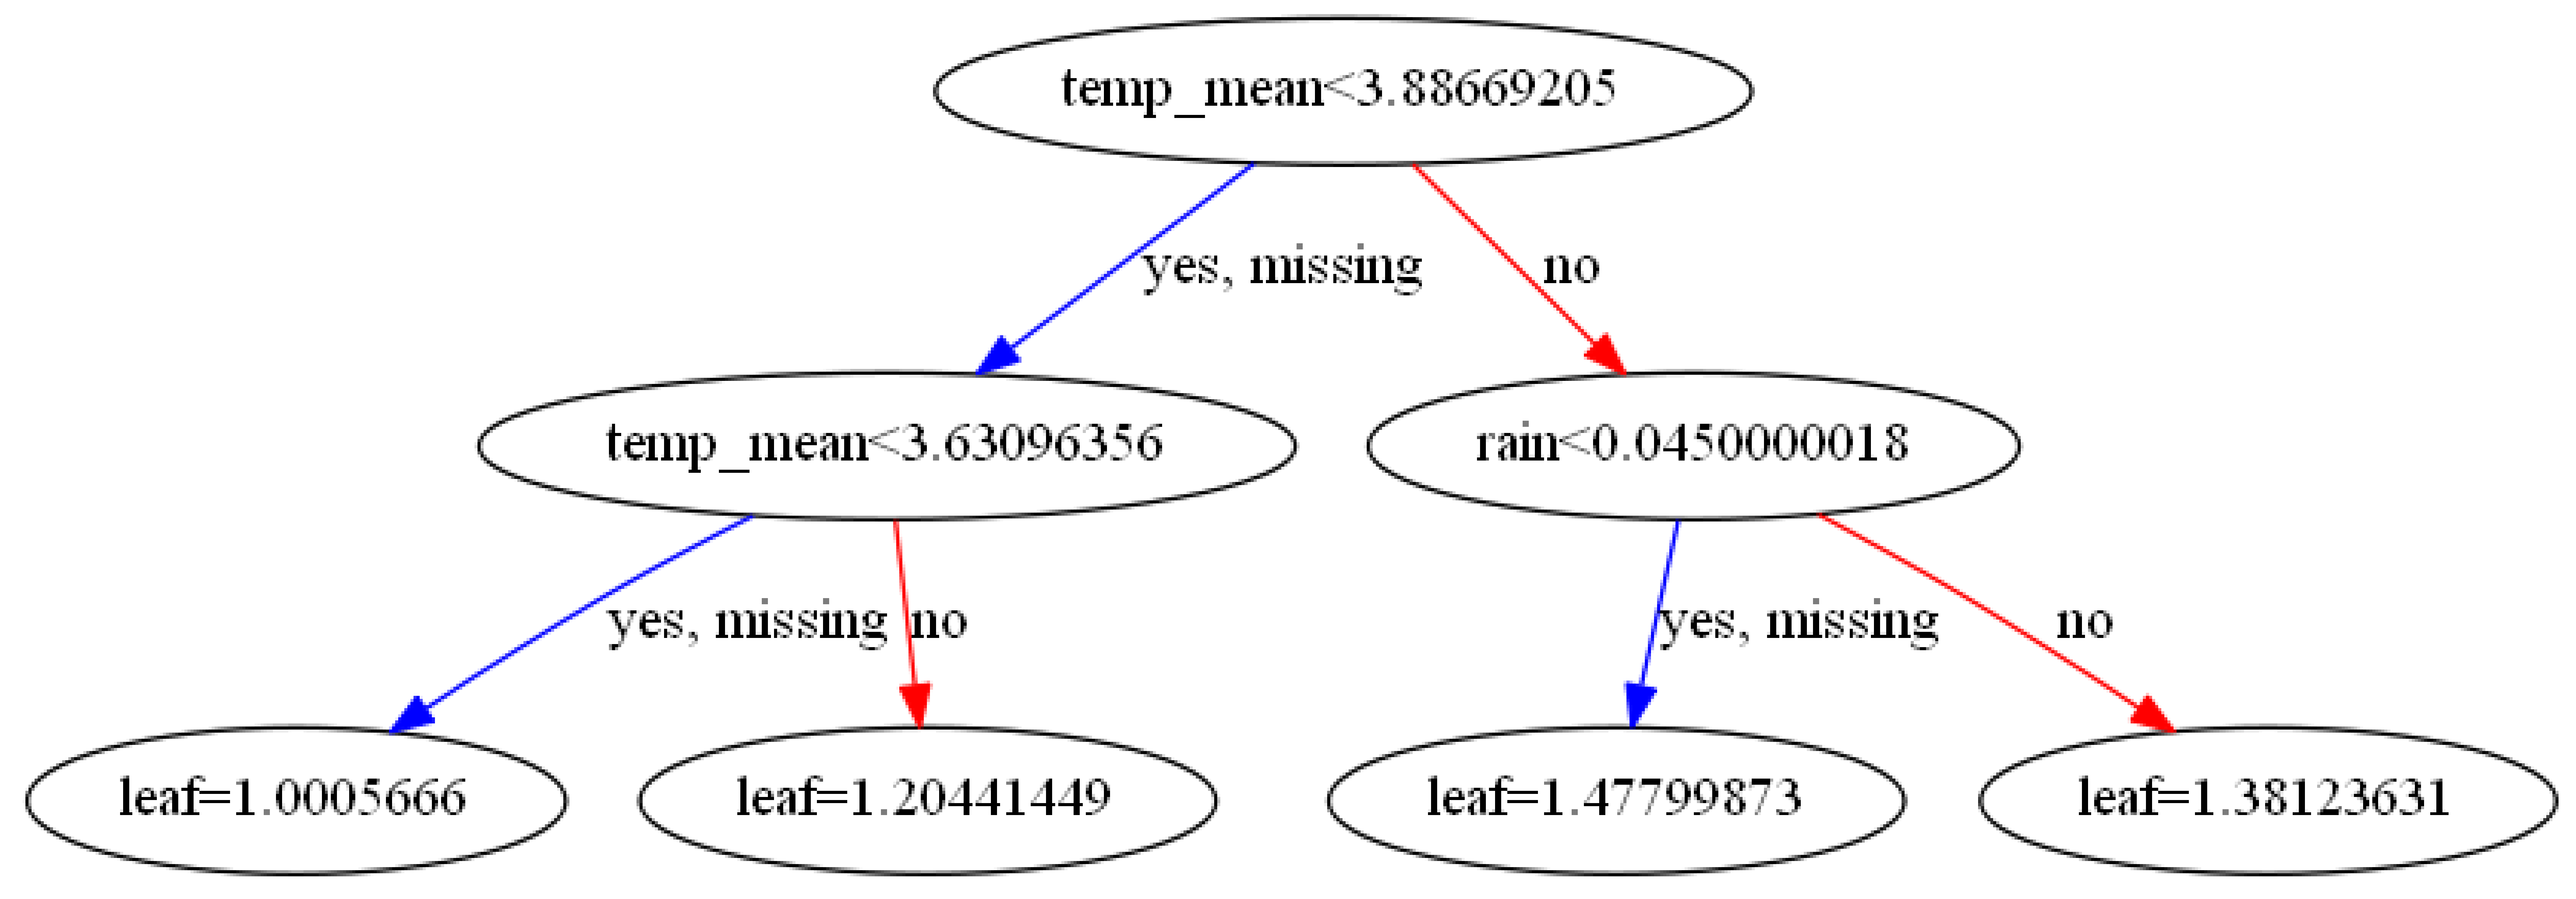

In [36]:

#Linear base learners example: learning API only
import xgboost as xgb


DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=10)
preds = xg_reg.predict(DM_test)
R2_score = r2_score(y_test, preds)
RSME_score = np.sqrt(mean_squared_error(y_test, preds))
"""Visualizing individual XGBoost trees
 Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire dataset."""

print('R2 score: ', R2_score)
print('RMSE: ', RSME_score)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)
Feature_selected_model["XgBoost_selected"] = xg_reg

In [37]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_features= 'auto',
                               n_estimators=500,
                               min_samples_leaf = 2,
                               random_state=2)
# Fit gb to the training set
gb.fit(X_train, y_train)
Feature_selected_model["Gradient_Boosting_selected"] = gb
# Predict test set labels
y_pred = gb.predict(X_test)


# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('GradientBoostingRegressor')
# Compute and print R^2 and RMSE
print("R^2: {}".format(gb.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('RMSE: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(gb,X_test,y_test,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

GradientBoostingRegressor
R^2: 0.9296409136800446
RMSE: 0.148

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.92450865 0.92735959 0.92423673 0.92998164 0.92693682]
Average 5-Fold CV Score: 0.9266046838230855


Lasso Regression :
R2 score:  0.6788818008849888
RMSE:  0.3161903511671946


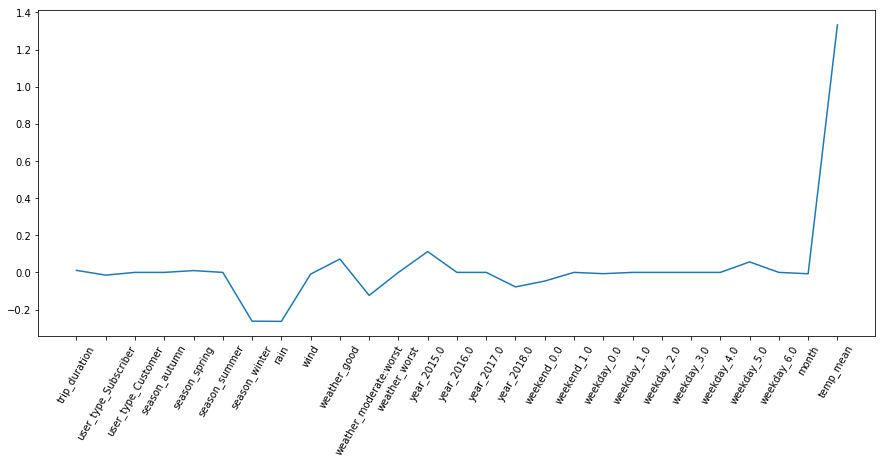

In [38]:
# Import Lasso
from sklearn.linear_model import Lasso

df_columns = pd.DataFrame(X_train)
df_columns.shape

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha = .0001,normalize = True)

# Fit the regressor to the data
lasso.fit(X_train,y_train)
Feature_selected_model["Lasso_selected"] = lasso
# Compute and print the coefficients
lasso_coef = lasso.coef_
validate_result(lasso, 'Lasso Regression')
fig = plt.figure(figsize=(15,6))
# Plot the coefficients
plt.plot(range(len(df_columns.columns)), lasso.coef_);
plt.xticks(range(len(df_columns.columns)), df_columns.columns.values, rotation=60)

plt.show()


In [39]:

# Use the best parameters found from above to build the model

rf_regressor = RandomForestRegressor(n_estimators = 200,min_samples_split= 2,min_samples_leaf= 1, max_features = 'auto') 
rf_regressor.fit(X_train,y_train)
Feature_selected_model["RF_Regression_selected"] = rf_regressor
# Predicting the values 

y_pred = rf_regressor.predict(X_test) 

In [40]:

# Compute MSE
mse_test = MSE(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# Compute and print R^2 and RMSE
print("R^2: {}".format(rf_regressor.score(X_test, y_test)))

# Compute RMSE
rmse_test = mse_test**(1/2)

# Print RMSE
print('Test set RMSE of regressor: {:.3f}'.format(rmse_test))

print("\n Compute 5-fold cross-validation scores on all the features")
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(rf_regressor,X_train,y_train,cv = 5)

# Print the 5-fold cross-validation scores
print(f'R^2 scores: {cv_scores}')

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

R^2: 0.9993003408407285
Test set RMSE of regressor: 0.015

 Compute 5-fold cross-validation scores on all the features
R^2 scores: [0.99974979 0.999855   0.99991405 0.99984895 0.99997597]
Average 5-Fold CV Score: 0.9998687530883433


In [23]:

# Create a ridge regressor: ridge
ridge = Ridge(alpha = 0.01,normalize = True)


ridge = ridge.fit(X_train,y_train)
validate_result(ridge,"Ridge")
Feature_selected_model['Ridge_selected'] = ridge

Ridge :
R2 score:  0.7199296866053274
RMSE:  0.2952906472883729


In [138]:
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_colwidth', 200)
pd.DataFrame(list(Tuned_models.items()))

,0,1
0,Lasso_all,"Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,\n normalize=True, positive=False, precompute=False, random_state=None,\n selection='cyclic', tol=0.0001, warm_start=False)"
1,Ridge_all,"Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,\n normalize=True, random_state=None, solver='auto', tol=0.001)"
2,DT_all,"DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,\n max_leaf_nodes=100, min_impurity_decrease=0.0,\n min_impurity_split=None, min_samples_leaf=20,\n ..."
3,LinearReg_all,"Pipeline(memory=None,\n steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg_all', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,\n normal..."
4,RandomForest_all,"(DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',\n max_leaf_nodes=None, min_impurity_decrease=0.0,\n min_impurity_split=None, min_samples_leaf=1,\n ..."
5,Xgboost_all,<xgboost.core.Booster object at 0x000001B3E86A3F60>
6,GadientBoosting_all,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min..."


In [66]:
df7 = pd.DataFrame(list(Feature_selected_model.items()))

In [24]:
score_results = pd.read_csv('D:/sr/mresults.csv')
score_results

,model name,R^2 (tuned),RMSE (tuned),Average 5-fold cross-validation R^2
0,Lasso,0.678882,0.316190,NaN
1,Ridge,0.721471,0.294477,NaN
2,Decision Tree,0.763611,0.271288,0.761225
3,LinearRegression,0.721549,0.294436,0.716030
4,RandomForest,0.999280,0.015000,0.999786
5,Xgboost,0.684514,0.313405,NaN
6,GadientBoosting,0.927277,0.150000,0.923912
7,Lasso_selected_features,0.678882,0.316190,NaN
8,Ridge_selected_features,0.719930,0.295291,NaN
9,Decision_tree_selected_features,0.763611,0.271288,0.761225


D:\sk\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


<Figure size 1080x576 with 0 Axes>

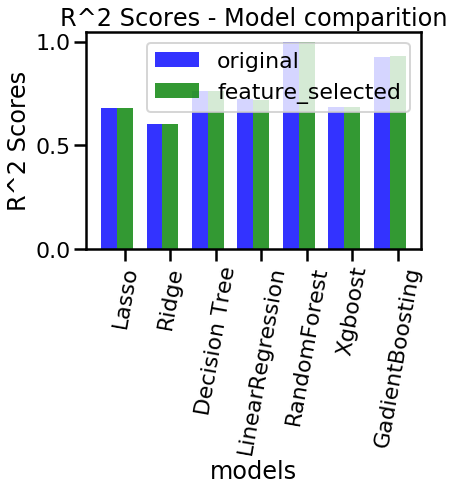

In [145]:

# data to plot
n_groups = 7
original = score_results['R^2 (tuned)'][0:7]
fs = score_results['R^2 (tuned)'][7:]
fig = plt.figure()
# create plot
fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, original, bar_width,alpha=opacity,color='b',label='original')

rects2 = plt.bar(index + bar_width, fs, bar_width,alpha=opacity,color='g',label='feature_selected')

plt.xlabel('models')
plt.ylabel('R^2 Scores')
plt.title('R^2 Scores - Model comparition')
plt.xticks(index + bar_width, ('Lasso','Ridge','Decision Tree','LinearRegression','RandomForest','Xgboost','GadientBoosting'),rotation=80)
plt.legend()

plt.tight_layout()
plt.show()